# HW2_2 - Probability Distributions 3 and Mixture Models

Learning contents:

1. Histogram-based density estimation
    - Display histogram densities
2. Kernel density estimation
    - Hypercube Kernel function
    - Gaussian Kernel function
3. K-Nearest Neigbours classification
    - Generate data
    - Classification function
    - Display results
4. K-Means clustering
    - Display results

## Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from math import sqrt
from collections import Counter
from scipy.stats import norm
from sklearn import datasets
from IPython.display import HTML

import seaborn as sns; sns.set(); sns.set_palette('bright')

## Generate data

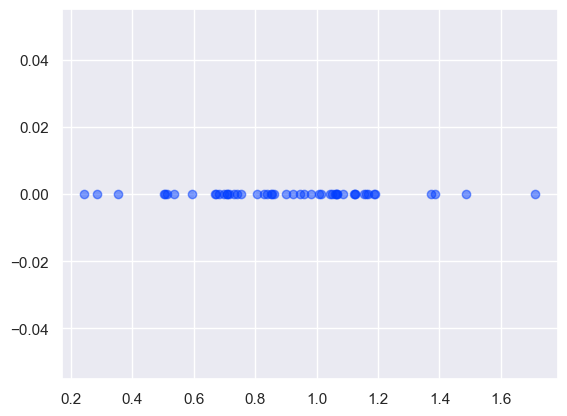

In [2]:
def generate_data_1D(size, means, variances, pis):
    result = 0
    
    for i, (mean, variance, pi) in enumerate(zip(means, variances, pis)):
        result += pi * np.array(norm(mean, sqrt(variance)).rvs(size=size, random_state=26 + i))
    
    return result
    
means = [0.4, 2.0]
variances = [0.2, 0.1]
pis = [0.7, 0.3]
data_1D = generate_data_1D(50, means, variances, pis)

plt.scatter(data_1D, [0] * len(data_1D), alpha=0.5)

## 1) Histogram-based density estimation

`histogram` takes `data`, bin size `delta` and returns `bins` (list of bins where `bin = list of points`) and their `probabilities`

In [3]:
def histogram(data, delta):
    # we will calculate The leftmost and rightmost bin edges
    first_edge = min(data)
    last_edge = max(data)
    # we will calculate the number of bins based on the range of data and the bin size delta
    num_bins = int((last_edge - first_edge) / delta)+1
    # create an empty list to store the bins
    bins = [[] for _ in range(num_bins)]
    # we will iterate over each data point and assign it to the corresponding bin
    for point in data:
        bin_index = int((point - first_edge) / delta)
        bins[bin_index].append(point)
    # Calculate the probabilities of each bin
    probabilities = [len(bin_points) / len(data) for bin_points in bins]
    # Return the bins and their probabilities
    return bins, probabilities

### 1.1) Display histogram densities

In [4]:
def display_histogram_density(data, delta):
    bins, probabilities = histogram(data, delta)

    plt.bar(range(len(bins)), list(map(lambda b: len(b), bins)))
    plt.plot(range(len(probabilities)), probabilities, '-r')


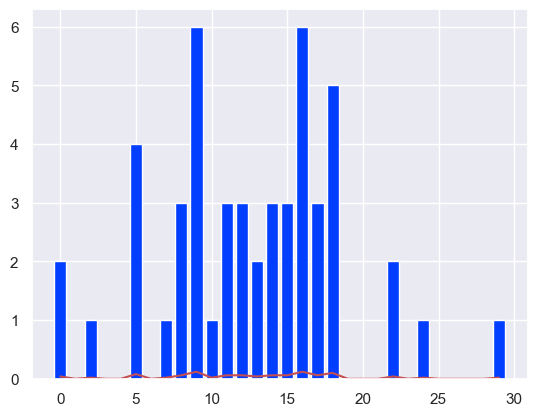

In [5]:
display_histogram_density(data_1D, 0.05)

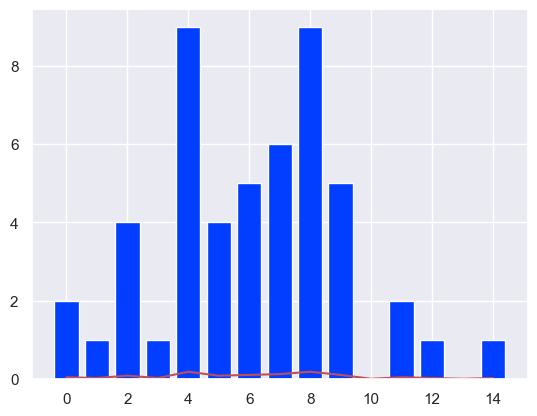

In [6]:
display_histogram_density(data_1D, 0.1)

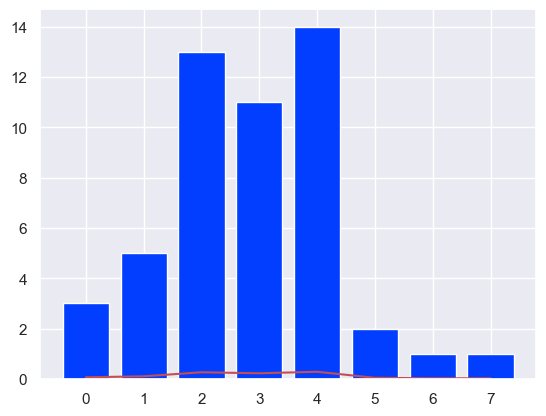

In [7]:
display_histogram_density(data_1D, 0.2)

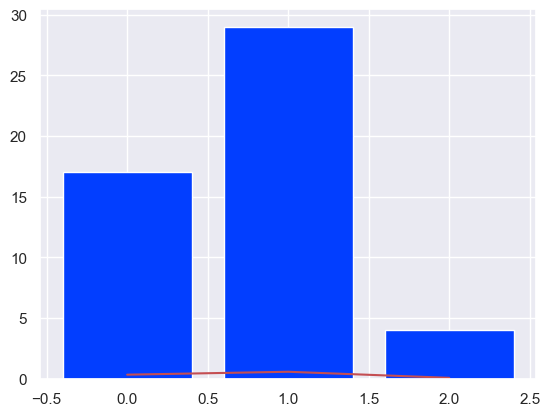

In [8]:
display_histogram_density(data_1D, 0.5)

## 2) Kernel density estimation

### 2.1) Hypercube Kernel function

`hypercube_kernel_function` takes `u` and returns 0 or 1 if `u` is inside 1/2 hypercube

In [9]:
def hypercube_kernel_function(u):
    # we will check if the absolute value of the input is greater than 0.5
    if abs(u) > 0.5:
        return 0
    else:
        return 1

`hypercube_kernel_density` takes any point `x`, data points `data`, size of a cube `h`, amount of dimensions `D` and returns probability density function based on Hypercube kernel function

 The hypercube_kernel_density function estimates the probability density function based on the Hypercube kernel function for a given point x and a set of data points data.

In [10]:
def hypercube_kernel_density(x, data, h, D):
    num_points = len(data)  # Number of data points
    num_dimensions = D     # Amount of Dimensions
    numerator = 0     # Numerator of the density estimate
    denominator = num_points * (h**D) # Denominator of the density estimate
    for point in data:
        diff = abs(point - x) / h # The abs function is used to ensure a positive value
        kernel_value = hypercube_kernel_function(diff) 
        numerator += kernel_value
    density = numerator / denominator
    return density
   

In [11]:
def display_hypercube_kernel_density_1D(data, h, color='b'):
    xs = np.linspace(min(data), max(data), 200)
    plt.plot(xs, list(map(lambda x: hypercube_kernel_density(x, data, h, 1), xs)), '-' + color, label='h=' + str(h))
    plt.legend()

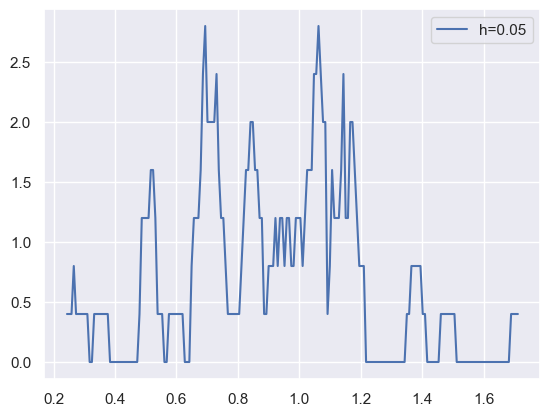

In [12]:
display_hypercube_kernel_density_1D(data_1D, 0.05, 'b')

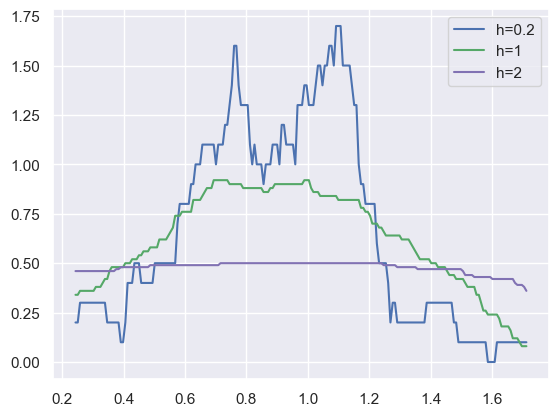

In [13]:
display_hypercube_kernel_density_1D(data_1D, 0.2, 'b')
display_hypercube_kernel_density_1D(data_1D, 1, 'g')
display_hypercube_kernel_density_1D(data_1D, 2, 'm')

### 2.2) Gaussian Kernel function

`gaussian_kernel_function` takes pair of points `x` and `x_n`, size `h` and returns Gaussian kernel function for this pair of points

In [14]:
def gaussian_kernel_function(x, x_n, h):
    return np.exp(-0.5 * ((x - x_n) / h) ** 2) / (h * np.sqrt(2 * np.pi))

`gaussian_kernel_density` takes any point `x`, data points `data`, size `h` and returns Gaussian kernel density for point `x`

In [15]:
def gaussian_kernel_density(x, data, h):
    num_points = len(data)  # Number of data points
    num_dimensions = 1  # Number of dimensions in x
    
    # Calculate the kernel density estimate
    numerator = 0  # Numerator of the density estimate
    denominator = num_points * h**num_dimensions  # Denominator of the density estimate
    
    for point in data:
        # Calculate the Gaussian kernel function value for the pair (x, point)
        kernel_value = gaussian_kernel_function(x, point, h)
        numerator += kernel_value
        density = numerator / denominator
    
    return density

In [16]:
def display_gaussian_kernel_density_1D(data, h, color='b'):
    xs = np.linspace(min(data), max(data), 200)
    plt.plot(xs, list(map(lambda x: gaussian_kernel_density(x, data, h), xs)), '-' + color, label='h=' + str(h))
    plt.legend()

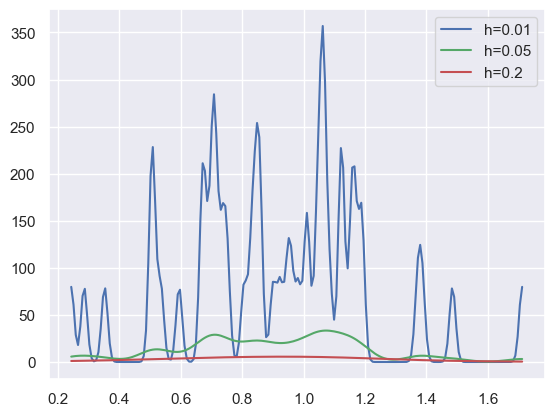

In [17]:
display_gaussian_kernel_density_1D(data_1D, 0.01, 'b')
display_gaussian_kernel_density_1D(data_1D, 0.05, 'g')
display_gaussian_kernel_density_1D(data_1D, 0.2, 'r')

## 3) K-Nearest Neigbours classification

### 3.1) Generate Data

(<matplotlib.collections.PathCollection at 0x25ed9cbf430>,
 <matplotlib.legend.Legend at 0x25ed9cbf790>)

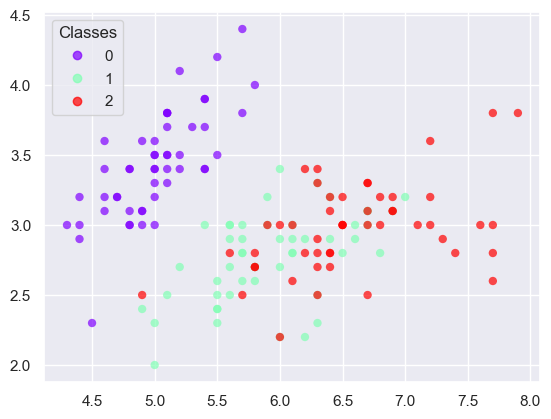

In [18]:
iris = datasets.load_iris()
iris_x = np.array(iris.data[:, :2])  # we only take the first two features.
iris_t = np.array(iris.target)

def plot_iris(legend=True, classes=iris_t, target=plt):
    scatter = target.scatter(iris_x[:, 0], iris_x[:, 1], c=classes, alpha=0.7, cmap='rainbow', edgecolor='none')
    if legend:
        legend = target.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
        return (scatter, legend)
    return (scatter, )

plot_iris()

### 3.2) Classification function

`k_nearest_classification` takes any point `x`, data point positions `data_x`, their classes `data_t`, amount of neighbours `k` and returns class for the point `x`

In [19]:
from scipy.spatial.distance import cdist
from scipy.spatial import distance

In [20]:
def k_nearest_classification(x, data_x, data_t, k):
    # Compute the distances between the point x and all data points
    distances = cdist(np.array([x]), data_x)[0]
# we use the cdist function to calculate the distances. The resulting distances array contains the distances between x and each data point in data_x
   
    # Find the indices of the k nearest neighbors
    nearest_indices = np.argsort(distances)[:k]
# the np.argsort function obtains the indices that would sort the distances array in ascending order. The [:k] part selects the first k indices, representing the k nearest neighbors  
    
    # Get the classes of the k nearest neighbors
    nearest_classes = data_t[nearest_indices]
# This step set indexes that are retrieved from the previous step    

    # Count the occurrences of each class
    class_counts = np.bincount(nearest_classes)
#  the np.bincount function counts the number of occurrences of each non-negative integer value in an array

    # Find the class with the maximum count
    predicted_class = np.argmax(class_counts)
# it the class with the maximum count among the k nearest neighbors. It uses the np.argmax function to return the index of the maximum value in the class_counts array, which corresponds to the predicted class   
    return predicted_class

### 3.3) Display results

In [21]:
def plot_mesh(pred_fn, n_class=3, x_min=4, x_max=8, y_min=2, y_max=4.5, target=plt):
    h = 0.1  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = np.array(list(map(lambda x: pred_fn(np.array(x)), np.c_[xx.ravel(), yy.ravel()])))
    Z = Z.reshape(xx.shape)
    cs = target.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))
    target.axis('tight')
    if hasattr(target, 'xlim'):
        target.xlim(x_min, x_max)
        target.ylim(y_min, y_max)

C:\Users\User\AppData\Local\Temp\ipykernel_12872\3786169586.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cs = target.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))


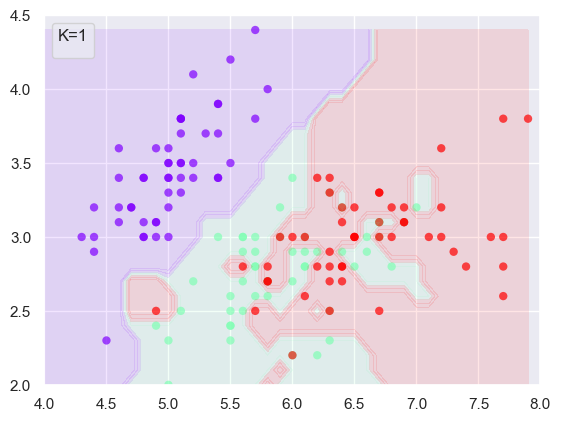

In [22]:
plot_iris(False)
plot_mesh(lambda x: k_nearest_classification(x, iris_x, iris_t, 1))
plt.legend([], loc="upper left", title="K=1")

C:\Users\User\AppData\Local\Temp\ipykernel_12872\3786169586.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cs = target.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))


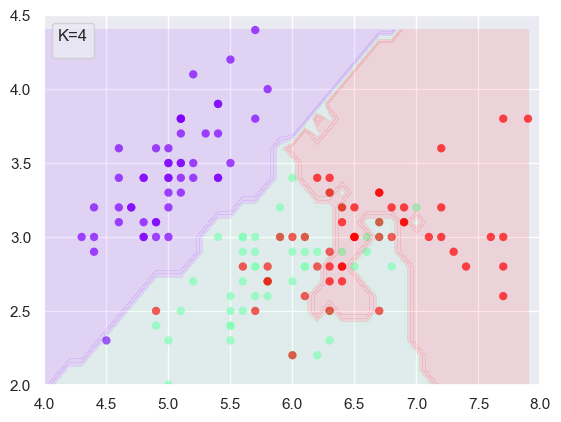

In [23]:
plot_iris(False)
plot_mesh(lambda x: k_nearest_classification(x, iris_x, iris_t, 4))
plt.legend([], loc="upper left", title="K=4")

C:\Users\User\AppData\Local\Temp\ipykernel_12872\3786169586.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cs = target.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))


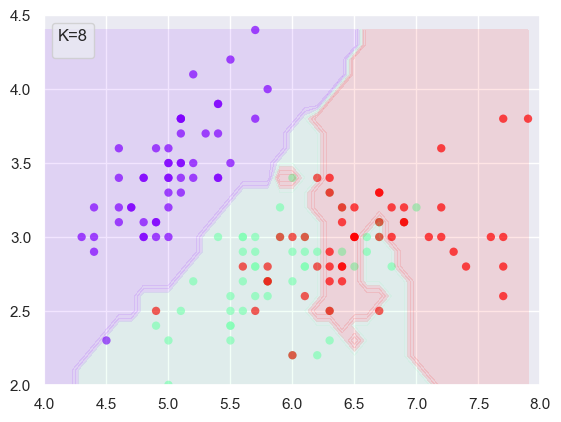

In [24]:
plot_iris(False)
plot_mesh(lambda x: k_nearest_classification(x, iris_x, iris_t, 8))
plt.legend([], loc="upper left", title="K=8")

## 4) K-Means clustering

`k_means_step` takes initial means `mus_0`, data points `data_x` and returns new means `mus` and `classes`

In [25]:
def k_means_step(mus_0, data_x):
    K = len(mus_0) # Number of clusters
    mus = np.zeros_like(mus_0)  # Initialize the new means
    classes = np.zeros(len(data_x), dtype=int) # Initialize the class assignments
    
    # Assign each data point to the nearest mean
    for i, x in enumerate(data_x):
        distances = distance.cdist(np.array([x]), mus_0)[0] # Compute the distances to all means
        nearest_mean_index = np.argmin(distances) # Find the index of the nearest mean  
        classes[i] = nearest_mean_index # Assign the data point to the nearest mean
    
    # Update the means based on the assigned data points
    for k in range(K):
        assigned_points = data_x[classes == k] # Select the data points assigned to the current mean
        mus[k] = np.mean(assigned_points, axis=0)  # Update the mean by taking the average of the assigned data points
    
    return mus, classes

`distortion_measure` takes means `mus`, `classes`, data points `data_x` and returns distortion of this classification

In [26]:
def distortion_measure(mus, classes, data_x):
    
    result = 0
    
    for i, c in enumerate(classes):
        
        x = data_x[i]
        mu = mus[c]
        distance = np.dot(np.array(mu) - np.array(x), np.array(mu) - np.array(x))
        result += distance
    
    return result

`optimize_k_means` takes initial means `mus_0`, data points `data_x` and callback `on_step`

`on_step` is a function that takes current `mus` and `classes` and should be called each step 

In [27]:
def optimize_k_means(mus_0, data_x, on_step):
    mus = np.copy(mus_0)
    n_iterations = 0
    
    while True:
        classes = k_means_step(mus, data_x)[1]  # Assign the classes using k_means_step
        n_iterations += 1
        on_step(mus, classes)
        
        mus_new = np.copy(mus)  # Make a copy of the current means
        
        # Update the means based on the assigned data points
        for k in range(len(mus)):
            assigned_points = data_x[classes == k]  # Select the data points assigned to the current mean
            mus_new[k] = np.mean(assigned_points, axis=0)  # Update the mean by taking the average of the assigned data points
            
        if np.allclose(mus, mus_new):
            break

        mus = np.copy(mus_new)

    return mus, classes                

### 4.1) Display results

In [28]:
def plot_k_means(mus, classes, target=plt):
    plot = plot_iris(classes=classes, target=target)
    scatter = target.scatter(mus[:, 0], mus[:, 1], c=[0, 1, 2], cmap='rainbow', marker='X', s=300, edgecolors='black')
    return (*plot, scatter)

In [29]:
k = 3
mus_0 = iris_x[:k]

all_steps = []

optimize_k_means(mus_0, iris_x, lambda mus, classes: all_steps.append((mus, classes)))

(array([[6.81276596, 3.07446809],
        [5.77358491, 2.69245283],
        [5.006     , 3.428     ]]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]))

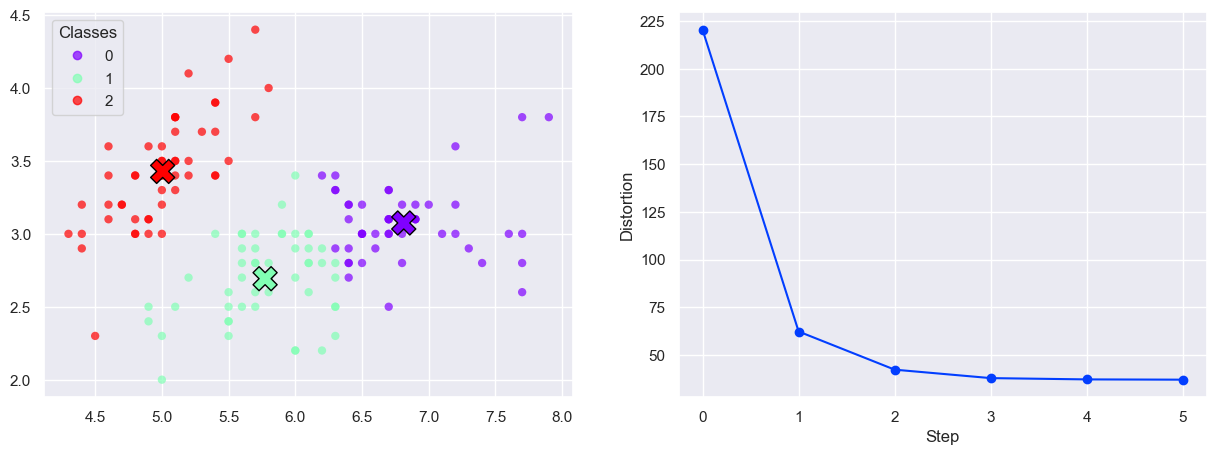

In [30]:
def create_animation(all_steps, data_x):
    
    distortions = list(map(
        lambda a: distortion_measure(a[0], a[1], data_x),
        all_steps
    ))
    
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    def animate(i):
        ax.cla()
        ax2.cla()
        
        plot1 = plot_k_means(all_steps[i][0], all_steps[i][1], target=ax)
        ax2.plot(list(range(i)), distortions[:i], '-o')
        plt.xlabel('Step')
        plt.ylabel('Distortion')
        return plot1
    
    anim = FuncAnimation(
        fig, animate,
        frames=len(all_steps), interval=500, blit=True
    )
    return HTML(anim.to_html5_video())

create_animation(all_steps, iris_x)